# YouTube trending videos

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from helpers.files import load_csv

gb_videos, us_videos = load_csv("youtube_data")
videos = pd.concat([gb_videos, us_videos])

    trending_date  count
0        18.17.02    400
1        18.08.02    400
2        18.10.03    400
3        17.19.11    400
4        18.19.01    400
..            ...    ...
200      18.24.05    355
201      18.21.05    354
202      18.23.05    353
203      18.22.05    352
204      18.15.05    347

[205 rows x 2 columns]


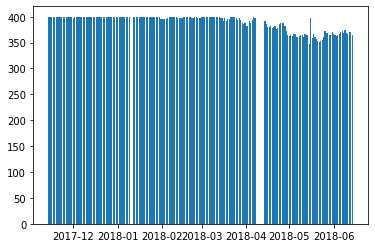

8735


In [3]:
publish_time_counts = videos["trending_date"].value_counts()
publish_time_counts = publish_time_counts.rename_axis("trending_date").reset_index(name="count")

print(publish_time_counts)
plt.bar(pd.to_datetime(publish_time_counts["trending_date"], format="%y.%d.%m"), publish_time_counts["count"])
plt.show()

gb_videos, us_videos = load_csv("clustering_data")
videos = pd.concat([gb_videos, us_videos])
videos = videos[videos["new_category_id"].notna()]
print(len(videos))

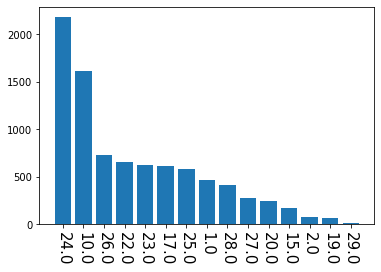

In [5]:
attr_c = videos["new_category_id"].value_counts()
attr_c = attr_c.rename_axis("new_category_id").reset_index(name="count")
labels = [str(i) for i in attr_c["new_category_id"]]
plt.bar(labels, attr_c["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

## Etap 5 - Zbieranie danych nie-trending

### Skrypt do zbierania danych trending

Pierwszym krokiem, który został wykonany w ramach tego etapu było
zapoznanie się z oryginalnym skryptem do pobierania danych „trending".
Skrypt jest dostępny w repozytorium [Trending-Youtube-Scraper](https://github.com/mitchelljy/Trending-YouTube-Scraper).

Oryginalny skrypt do pobierania danych -> w jego
kontekscie można opisać dlaczego tak pobieramy

### Pomysł na pobranie danych nie trending

- Podział okresu 11.2017-07.2018 na 4 podokresy
- Zbieranie danych „proporcjami” wystąpień kategorii podobnymi do oryginalnych
- Filtrowanie filmów trending
- Filtrowanie ewentualnych powtórzeń
- Uzupełnianie statystyk

Testowe dane

In [11]:
gb_downloaded = load_csv("ped5_data-copy")[0]

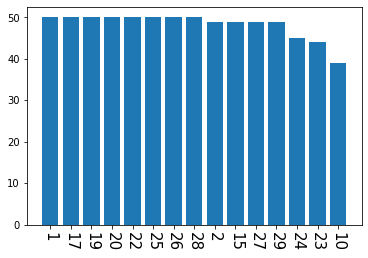

In [12]:
attr_c = gb_downloaded["category_id"].value_counts()
attr_c = attr_c.rename_axis("category_id").reset_index(name="count")
labels = [str(i) for i in attr_c["category_id"]]
plt.bar(labels, attr_c["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()
